## Loading the Libraries

In [1]:
from datasets import load_dataset
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sqlite3
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, auc, ConfusionMatrixDisplay, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE

In [2]:
# Load the dataset
dataset = load_dataset("Manisha12Researcher/hospital_mortality_data")

# Combine all splits into a single DataFrame
all_splits = []
for split_name, split_data in dataset.items():
    # Convert each split to a DataFrame
    df_split = split_data.to_pandas()
    all_splits.append(df_split)

# Concatenate all splits
df = pd.concat(all_splits, ignore_index=True)

# Display the first few rows of the dataset
print("First 5 rows of the dataset:")
print(df.head())

# Display basic information about the dataset
print("\nDataset Information:")
print(df.info())

# Display summary statistics for numeric columns
print("\nSummary Statistics:")
print(df.describe())


First 5 rows of the dataset:
   group      ID  outcome  age  gendera        BMI  hypertensive  \
0      1  125047      0.0   72        1  37.588179             0   
1      1  139812      0.0   75        2        NaN             0   
2      1  109787      0.0   83        2  26.572634             0   
3      1  130587      0.0   43        2  83.264629             0   
4      1  138290      0.0   75        2  31.824842             1   

   atrialfibrillation  CHD with no MI  diabetes  ...  Blood sodium  \
0                   0               0         1  ...    138.750000   
1                   0               0         0  ...    138.888889   
2                   0               0         0  ...    140.714286   
3                   0               0         0  ...    138.500000   
4                   0               0         0  ...    136.666667   

   Blood calcium    Chloride  Anion gap  Magnesium ion     PH  Bicarbonate  \
0       7.463636  109.166667  13.166667       2.618182  7.230  

In [3]:
#Check for missing data
print("\nMissing Values per Column:")
print(df.isnull().sum())


Missing Values per Column:
group                         0
ID                            0
outcome                       1
age                           0
gendera                       0
BMI                         215
hypertensive                  0
atrialfibrillation            0
CHD with no MI                0
diabetes                      0
deficiencyanemias             0
depression                    0
Hyperlipemia                  0
Renal failure                 0
COPD                          0
heart rate                   13
Systolic blood pressure      16
Diastolic blood pressure     16
Respiratory rate             13
temperature                  19
SP O2                        13
Urine output                 36
hematocrit                    0
RBC                           0
MCH                           0
MCHC                          0
MCV                           0
RDW                           0
Leucocyte                     0
Platelets                     0
Neutrophils 

# Data Pre-Processing

## Initial Visualization

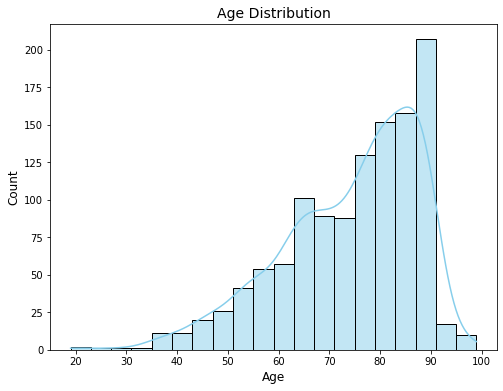

In [4]:
#Age Distribution

plt.figure(figsize=(8, 6))
sns.histplot(df['age'], bins=20, kde=True, color='skyblue')
plt.title('Age Distribution', fontsize=14)
plt.xlabel('Age', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

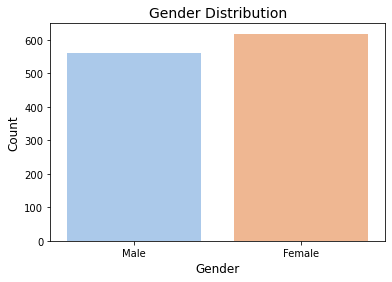

In [5]:
#Gender Distribution

plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='gendera', palette='pastel')
plt.title('Gender Distribution', fontsize=14)
plt.xlabel('Gender', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(ticks=[0, 1], labels=['Male', 'Female'])
plt.show()

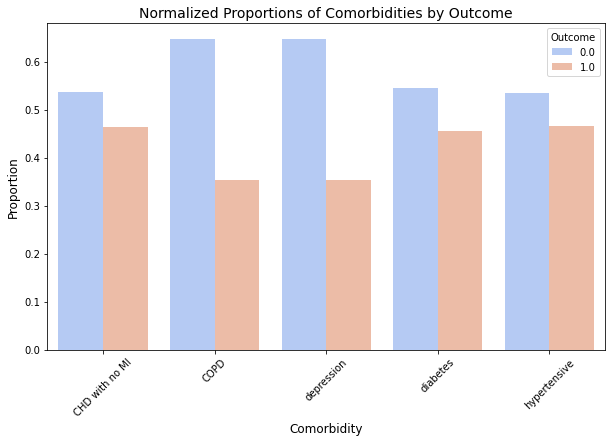

In [6]:
#Comorbidity Vs Outcome

comorbidities = ['hypertensive', 'diabetes', 'CHD with no MI', 'depression', 'COPD']
outcome_col = 'outcome'

# Melt the dataset for easier plotting
df_melted = df.melt(id_vars=[outcome_col], value_vars=comorbidities, 
                    var_name='Comorbidity', value_name='Presence')

# Calculate proportions normalized by each comorbidity
df_grouped = df_melted.groupby(['Comorbidity', outcome_col])['Presence'].mean().reset_index()

# Normalize so proportions sum to 1 for each comorbidity
df_grouped['Proportion'] = df_grouped.groupby('Comorbidity')['Presence'].transform(lambda x: x / x.sum())

# Plot normalized proportions
plt.figure(figsize=(10, 6))
sns.barplot(data=df_grouped, x='Comorbidity', y='Proportion', hue=outcome_col, ci=None, palette='coolwarm')
plt.title('Normalized Proportions of Comorbidities by Outcome', fontsize=14)
plt.xlabel('Comorbidity', fontsize=12)
plt.ylabel('Proportion', fontsize=12)
plt.legend(title='Outcome', loc='upper right')
plt.xticks(rotation=45)
plt.show()


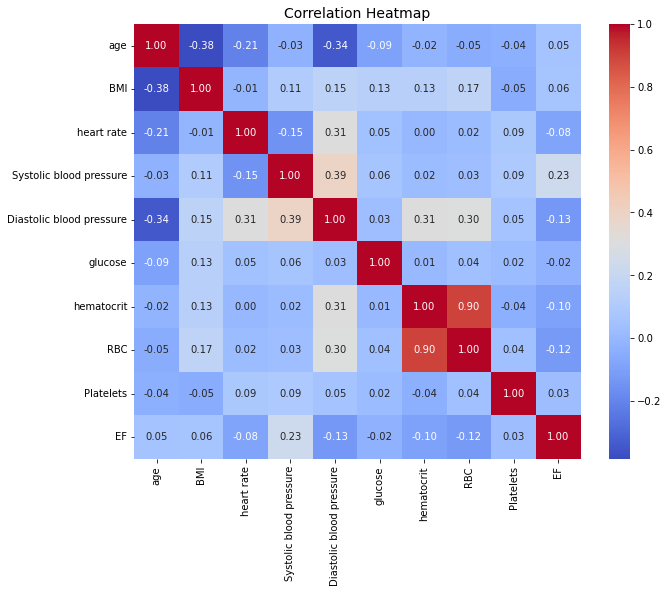

In [7]:
# Correlation HeatMap

continuous_cols = ['age', 'BMI', 'heart rate', 'Systolic blood pressure', 'Diastolic blood pressure', 
                   'glucose', 'hematocrit', 'RBC', 'Platelets', 'EF']

plt.figure(figsize=(10, 8))
corr_matrix = df[continuous_cols].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
plt.title('Correlation Heatmap', fontsize=14)
plt.show()

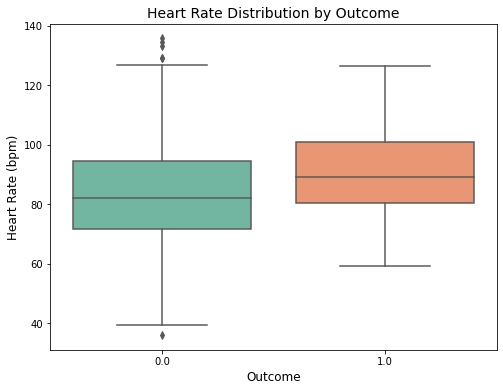

In [8]:
#Heart Rate Distribution by Outcome
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='outcome', y='heart rate', palette='Set2')
plt.title('Heart Rate Distribution by Outcome', fontsize=14)
plt.xlabel('Outcome', fontsize=12)
plt.ylabel('Heart Rate (bpm)', fontsize=12)
plt.show()

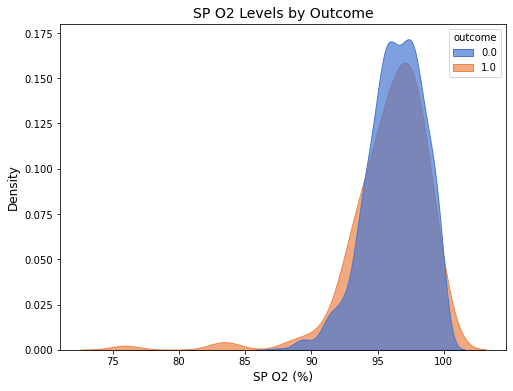

In [9]:
#A KDE plot to compare oxygen saturation levels between outcomes

plt.figure(figsize=(8, 6))
sns.kdeplot(data=df, x='SP O2', hue='outcome', fill=True, common_norm=False, palette='muted', alpha=0.7)
plt.title('SP O2 Levels by Outcome', fontsize=14)
plt.xlabel('SP O2 (%)', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.show()

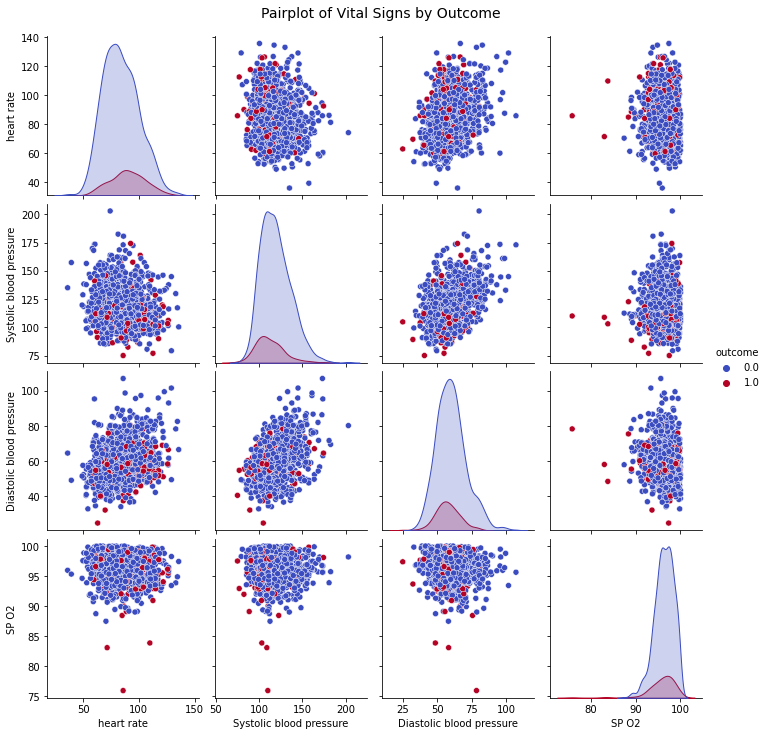

In [10]:
sns.pairplot(df, vars=['heart rate', 'Systolic blood pressure', 'Diastolic blood pressure', 'SP O2'], hue='outcome', palette='coolwarm')
plt.suptitle('Pairplot of Vital Signs by Outcome', y=1.02, fontsize=14)
plt.show()

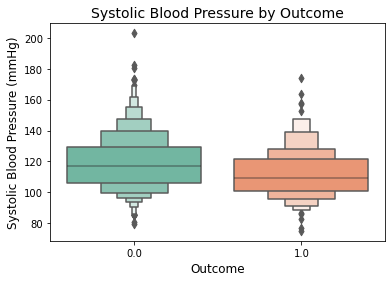

In [11]:
sns.boxenplot(data=df, x='outcome', y='Systolic blood pressure', palette='Set2')
plt.title('Systolic Blood Pressure by Outcome', fontsize=14)
plt.xlabel('Outcome', fontsize=12)
plt.ylabel('Systolic Blood Pressure (mmHg)', fontsize=12)
plt.show()


## Baseline Regression Model

In [12]:
# Define the target column and features
target_col = 'outcome'  # Replace with your actual outcome column name
exclude_cols = ['ID']  # Exclude irrelevant columns
feature_cols = [col for col in df.columns if col not in exclude_cols + [target_col]]

# Ensure no missing target values
df = df.dropna(subset=[target_col])

# Define features and target
X = df[feature_cols]
y = df[target_col]

#Dealing with missing values
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

# Check shapes to ensure consistency
print("Shape of X:", X_imputed.shape)
print("Length of y:", len(y))

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

# Train Logistic Regression
model1 = LogisticRegression(max_iter=1000, random_state=42)
model1.fit(X_train, y_train)

# Evaluate the model
y_pred1 = model1.predict(X_test)
y_pred_proba1 = model1.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred1))
print("AUC-ROC:", roc_auc_score(y_test, y_pred_proba1))

print("Classification Report:")
print(classification_report(y_test, y_pred1))

Shape of X: (1176, 49)
Length of y: 1176
Accuracy: 0.8559322033898306
AUC-ROC: 0.8146683673469387
Classification Report:
              precision    recall  f1-score   support

         0.0       0.86      0.98      0.92       196
         1.0       0.75      0.23      0.35        40

    accuracy                           0.86       236
   macro avg       0.81      0.60      0.63       236
weighted avg       0.84      0.86      0.82       236



/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


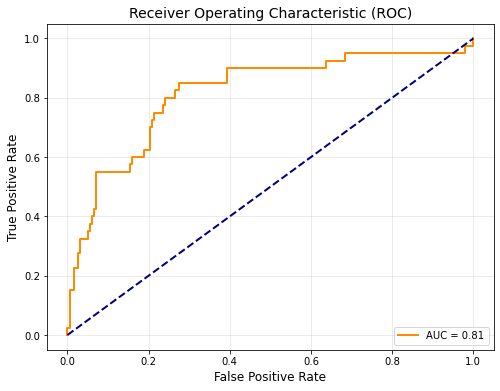

In [13]:
# Calculate the FPR (False Positive Rate), TPR (True Positive Rate), and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba1)

# Calculate the AUC
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.title('Receiver Operating Characteristic (ROC)', fontsize=14)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

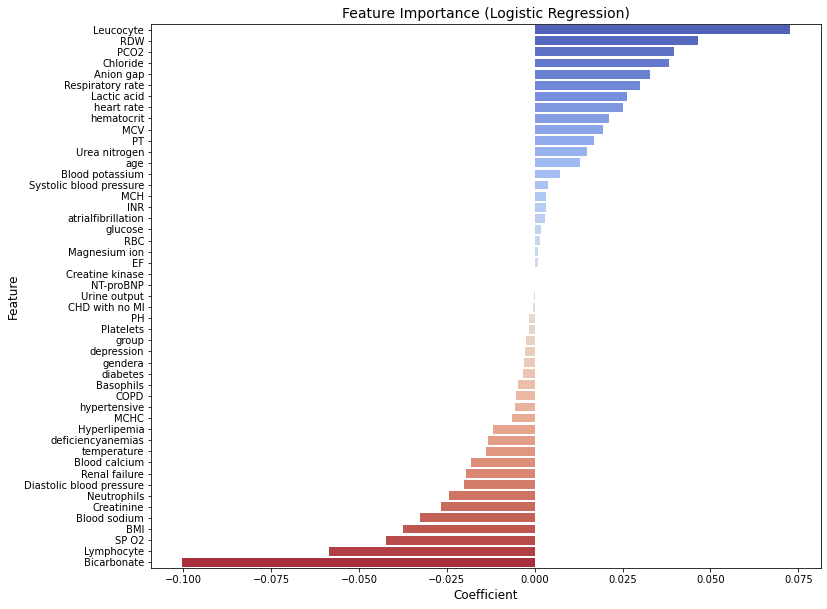

In [14]:
# Feature importance
coefficients = model1.coef_[0]  # Extract coefficients for features
feature_names = X.columns

# Create a DataFrame for visualization
importance_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
importance_df = importance_df.sort_values(by='Coefficient', ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 10))
sns.barplot(data=importance_df, x='Coefficient', y='Feature', palette='coolwarm')
plt.title('Feature Importance (Logistic Regression)', fontsize=14)
plt.xlabel('Coefficient', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.show()


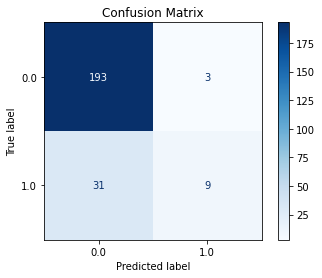

In [15]:
ConfusionMatrixDisplay.from_estimator(model1, X_test, y_test, cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

## Feature Engineering

In [16]:
# Connect to SQLite database
conn = sqlite3.connect('Mortality_data.db')

# Save the dataframe to a table in the database
df.to_sql('patient_data', conn, if_exists='replace', index=False)

1176

In [17]:
# SQL query to calculate the number of comorbidities per patient
query_comorbidities = """
SELECT 
    ID, 
    (hypertensive + diabetes + COPD + atrialfibrillation + "CHD with no MI" +
    deficiencyanemias + depression + hyperlipemia + "Renal failure") AS comorbidities
FROM 
    patient_data;
"""

# Execute the query and load the results into a DataFrame
comorbidities = pd.read_sql_query(query_comorbidities, conn)
print(comorbidities.head())

# Merge comorbidity data into the original DataFrame
comorbidities.set_index('ID', inplace=True)
df.set_index('ID', inplace=True)
df = df.merge(comorbidities, left_index=True, right_index=True, how='left')

# Reset the index for further processing
df.reset_index(inplace=True)


       ID  comorbidities
0  125047              4
1  139812              2
2  109787              2
3  130587              0
4  138290              4


In [18]:
#Hematocrit-to-RBC & Systolic-to-Diastolic BP Ratio

# Calculate Hematocrit-to-RBC Ratio
query_hematocrit_rbc = """
SELECT 
    ID, 
    hematocrit / RBC AS hematocrit_rbc_ratio 
FROM 
    patient_data;
"""
hematocrit_rbc_ratio = pd.read_sql_query(query_hematocrit_rbc, conn)

# Calculate Systolic-to-Diastolic BP Ratio
query_bp_ratio = """
SELECT 
    ID, 
    "Systolic blood pressure" / "Diastolic blood pressure" AS bp_ratio 
FROM 
    patient_data;
"""
bp_ratio = pd.read_sql_query(query_bp_ratio, conn)

# Merge the ratios into the main dataframe
hematocrit_rbc_ratio.set_index('ID', inplace=True)
bp_ratio.set_index('ID', inplace=True)

df.set_index('ID', inplace=True)
df = df.merge(hematocrit_rbc_ratio, left_index=True, right_index=True, how='left')
df = df.merge(bp_ratio, left_index=True, right_index=True, how='left')

# Reset index for the final DataFrame
df.reset_index(inplace=True)


## Logistic Regression with the changes

AUC: 0.8024234693877551
Accuracy: 0.86
Classification Report:
              precision    recall  f1-score   support

         0.0       0.87      0.97      0.92       196
         1.0       0.69      0.28      0.39        40

    accuracy                           0.86       236
   macro avg       0.78      0.62      0.66       236
weighted avg       0.84      0.86      0.83       236



/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


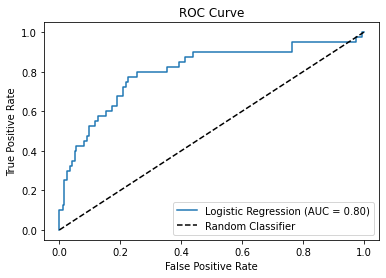

In [19]:
# Define features and target for logistic regression
X = df.drop(['ID', 'outcome', 'hypertensive', 'diabetes' , 'COPD' , 'atrialfibrillation' , "CHD with no MI" ,
             'deficiencyanemias' , 'depression' , 'Hyperlipemia' , "Renal failure", 'bp_ratio', 'hematocrit' , 'RBC' ], axis=1)  
y = df['outcome']

#Dealing with missing values
imputer = SimpleImputer(strategy='median')
X = imputer.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Logistic regression model
logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_train, y_train)

# Predictions and probabilities
y_pred = logistic_model.predict(X_test)
y_prob = logistic_model.predict_proba(X_test)[:, 1]  # Probability of the positive class

# Metrics
auc = roc_auc_score(y_test, y_prob)
print(f"AUC: {auc}")

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")


print("Classification Report:")
print(classification_report(y_test, y_pred))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)

import matplotlib.pyplot as plt

plt.plot(fpr, tpr, label=f"Logistic Regression (AUC = {auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

## Random Forest Model

In [20]:
# Define features and target for Random Forest
X = df.drop(['ID', 'outcome', 'hypertensive', 'diabetes' , 'COPD' , 'atrialfibrillation' , "CHD with no MI" ,
             'deficiencyanemias' , 'depression' , 'Hyperlipemia' , "Renal failure", 'bp_ratio', 'hematocrit' , 'RBC' ], axis=1)  
y = df['outcome']

#Dealing with missing values
imputer = SimpleImputer(strategy='median')
X= imputer.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# If target is binary (classification)
if y.nunique() == 2: # This is our case
    rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
    rf_model.fit(X_train, y_train)

    # Predictions and metrics
    y_pred = rf_model.predict(X_test)
    y_prob = rf_model.predict_proba(X_test)[:, 1]

    auc = roc_auc_score(y_test, y_prob)
    print(f"AUC: {auc:.2f}")
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.2f}")
    
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

# If target is continuous (regression)
else:
    rf_model = RandomForestRegressor(random_state=42, n_estimators=100)
    rf_model.fit(X_train, y_train)

    # Predictions and metrics
    y_pred = rf_model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"Mean Squared Error: {mse:.2f}")
    print(f"R^2 Score: {r2:.2f}")

AUC: 0.84
Accuracy: 0.85
Classification Report:
              precision    recall  f1-score   support

         0.0       0.85      0.99      0.92       196
         1.0       0.83      0.12      0.22        40

    accuracy                           0.85       236
   macro avg       0.84      0.56      0.57       236
weighted avg       0.85      0.85      0.80       236



Top Features by Importance:
          Feature  Importance
34    Bicarbonate    0.054006
31      Anion gap    0.044873
15      Leucocyte    0.044169
19     Lymphocyte    0.038553
10   Urine output    0.038397
35    Lactic acid    0.037927
29  Blood calcium    0.036594
33             PH    0.035058
25  Urea nitrogen    0.034516
30       Chloride    0.032196


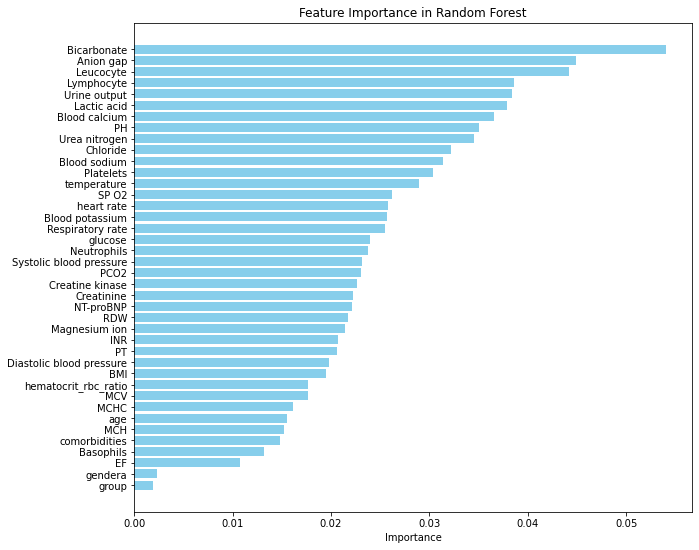

In [21]:
# Define feature names
feature_names = df.drop(['ID', 'outcome', 'hypertensive', 'diabetes', 'COPD', 'atrialfibrillation', "CHD with no MI",
                         'deficiencyanemias', 'depression', 'Hyperlipemia', "Renal failure", 'bp_ratio', 'hematocrit', 'RBC'], 
                        axis=1).columns

# Extract feature importance
feature_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Display the top features
print("Top Features by Importance:")
print(feature_importances.head(10))  # Top 10 features

# Plot feature importance
plt.figure(figsize=(10, 9))
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color='skyblue')
plt.gca().invert_yaxis()  # Invert y-axis to display highest importance at the top
plt.xlabel('Importance')
plt.title('Feature Importance in Random Forest')
plt.show()


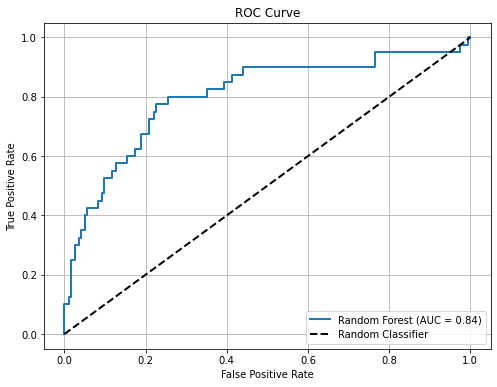

In [22]:
# Plot the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"Random Forest (AUC = {auc:.2f})", linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier", linewidth=2)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()

## Random Forest with Data Balancing

Original Class Distribution:
0.0    821
1.0    119
Name: outcome, dtype: int64

Balanced Class Distribution:
1.0    821
0.0    821
Name: outcome, dtype: int64
AUC: 0.81
Accuracy: 0.85


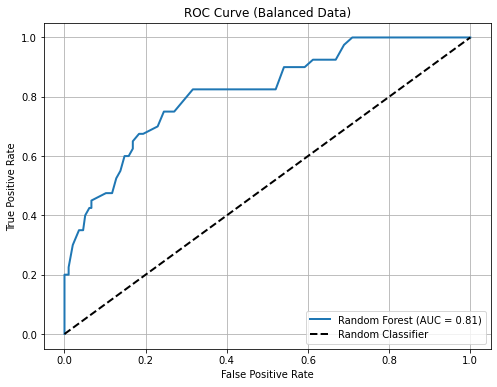

In [23]:
# Define features and target
X = df.drop(['ID', 'outcome', 'hypertensive', 'diabetes' , 'COPD' , 'atrialfibrillation' , "CHD with no MI" ,
             'deficiencyanemias' , 'depression' , 'Hyperlipemia' , "Renal failure", 'bp_ratio', 'hematocrit' , 'RBC' ], axis=1)  
y = df['outcome']

#Dealing with missing values
imputer = SimpleImputer(strategy='median')
X = imputer.fit_transform(X)

# Train-test split before applying SMOTE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to oversample the minority class
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Print class distributions before and after balancing
print("Original Class Distribution:")
print(y_train.value_counts())
print("\nBalanced Class Distribution:")
print(pd.Series(y_train_balanced).value_counts())

# Train Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X_train_balanced, y_train_balanced)

# Predict probabilities on the test set
y_prob = rf_model.predict_proba(X_test)[:, 1]

# Calculate AUC
auc = roc_auc_score(y_test, y_prob)
print(f"AUC: {auc:.2f}")
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Generate ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)

# Plot the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"Random Forest (AUC = {auc:.2f})", linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier", linewidth=2)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Balanced Data)")
plt.legend(loc="lower right")
plt.grid()
plt.show()
